In [1]:
!pip uninstall -y numpy
!pip install "numpy<2"

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import numpy as np
import seaborn as sns
from bertopic import BERTopic
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from umap import UMAP
import matplotlib.pyplot as plt
import datetime

## Obtención de datos necesarios

Necesitamos cargar el dataframe original para obtener los `statements`, que serán la entrada del modelo de BERTopics

In [ ]:
df = pd.read_csv("../../../../data/processed/data_limpieza_v2.csv")
df_statements = df["statement"]
df

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_affiliation_uni,party_affiliation_category_map
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,president-elect,new_york,republican,republican,political-affiliation
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,u.s. senator,connecticut,democrat,democrat,political-affiliation
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,political commentator,washington_dc,democrat,democrat,political-affiliation
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,non-define,non-define,none,none,other-political-groups
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,non-define,wisconsin,republican,republican,political-affiliation
...,...,...,...,...,...,...,...,...,...,...
8945,44edff2b865,1,If Rhode Island does a hybrid [retirement] pla...,"pensions,public-service,retirement,workers",lincoln-chafee,non-define,rhode_island,democrat,democrat,political-affiliation
8946,4a63b5f9c16,1,The new health care law will force seniors int...,"medicare,message-machine,retirement",dan-coats,non-define,indiana,republican,republican,political-affiliation
8947,7c57fa8e81c,0,The health insurance plan that (members of Con...,health-care,steve-southerland,"u.s. representative, florida district 2",florida,republican,republican,political-affiliation
8948,2375e3cf4b7,1,No one in American history has moved from a Ju...,"elections,history",newt-gingrich,"co-host on cnn's ""crossfire""",georgia,republican,republican,political-affiliation


## Uso de BERTopics

In [90]:
# Crear el modelo de topics
topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=True)

In [7]:
# Aplicar sobre statement
train_topics, _ = topic_model.fit_transform(df_statements)

2025-05-18 20:06:42,781 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

2025-05-18 20:08:37,141 - BERTopic - Embedding - Completed ✓
2025-05-18 20:08:37,142 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-18 20:09:23,884 - BERTopic - Dimensionality - Completed ✓
2025-05-18 20:09:23,888 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-18 20:09:24,484 - BERTopic - Cluster - Completed ✓
2025-05-18 20:09:24,498 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-18 20:09:24,965 - BERTopic - Representation - Completed ✓


In [91]:
# Almacenamos en el dataframe
df["topic"] = train_topics
#sorted(df["topic"].unique().tolist()) # Hay 115 categorias de topics

In [92]:
# Aplicar sobre subject
train_topics_subject, _ = topic_model.fit_transform(df["subject"])

2025-05-18 20:42:07,655 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

2025-05-18 20:42:31,579 - BERTopic - Embedding - Completed ✓
2025-05-18 20:42:31,580 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-18 20:42:50,292 - BERTopic - Dimensionality - Completed ✓
2025-05-18 20:42:50,296 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-18 20:42:50,737 - BERTopic - Cluster - Completed ✓
2025-05-18 20:42:50,744 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-18 20:42:51,048 - BERTopic - Representation - Completed ✓


In [93]:
# Almacenamos en el dataframe
df["topic_subject"] = train_topics_subject
#sorted(df["topic"].unique().tolist()) # Hay 115 categorias de topics

### Guardar resultado

In [94]:
# Guardamos los topics
topic_model.save("bertopic_model")

# Guardamos el dataset con los topics en csv
filename = f"../../data/processed/train_limpieza_v2_con_topics.csv"
df.to_csv(filename, index=False)
print(f"Dataframe con topics guardado en {filename}")

2025-05-18 20:42:51,848 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Dataframe con topics guardado en ../../data/processed/train_limpieza_v2_con_topics.csv


## Obtención de Embeddings

In [ ]:
embed_statements_df = pd.read_csv("../../../../data/processed/embedded_statements_top50.csv")
embed_statements_df.head(5)

,embed_288,embed_305,embed_367,embed_65,embed_212,embed_555,embed_49,embed_594,embed_597,embed_699,...,embed_306,embed_261,embed_736,embed_37,embed_478,embed_44,embed_584,embed_716,embed_303,embed_410
0,0.447432,0.121018,-0.069483,0.134221,-0.248795,0.215067,-0.232684,-0.020253,0.228698,-0.203384,...,-0.322277,-0.197435,-0.455960,0.117002,0.142312,-0.193179,0.245438,-0.197799,0.164803,-0.220516
1,0.182596,0.307907,0.178682,-0.021348,-0.220356,0.163040,-0.531990,0.068914,0.019741,-0.024272,...,-0.352578,0.315520,-0.239936,-0.116856,0.340613,-0.268858,0.372259,-0.149797,0.162053,-0.396436
2,0.241975,0.052680,0.318411,0.024792,0.002991,0.432318,-0.411519,0.011643,-0.291194,0.123477,...,-0.235163,0.048060,-0.112244,-0.485297,-0.035397,0.040565,0.276953,-0.078426,0.181235,-0.282160
3,0.119451,0.309935,0.136173,0.111591,-0.081198,0.111602,-0.333355,0.031573,0.219257,-0.277230,...,-0.207454,0.038440,-0.067346,-0.004748,-0.024534,-0.010385,-0.058753,-0.511931,-0.053076,-0.161608
4,0.292010,-0.150851,0.001530,0.064273,-0.047030,0.342163,-0.351950,0.170110,0.034435,-0.073670,...,-0.265253,-0.252458,0.051454,-0.507751,0.155899,0.311305,0.098975,-0.163689,-0.174877,0.094242


Juntamos los stamtements con el topic y lo guardamos en el dataframe con el que vamos a entrenar el modelo

In [128]:
train_df = embed_statements_df.copy()
train_df["topic"] = df["topic"]
train_df["topic_subject"] = df["topic_subject"]
train_df.head(3)

,embed_288,embed_305,embed_367,embed_65,embed_212,embed_555,embed_49,embed_594,embed_597,embed_699,...,embed_736,embed_37,embed_478,embed_44,embed_584,embed_716,embed_303,embed_410,topic,topic_subject
0,0.447432,0.121018,-0.069483,0.134221,-0.248795,0.215067,-0.232684,-0.020253,0.228698,-0.203384,...,-0.455960,0.117002,0.142312,-0.193179,0.245438,-0.197799,0.164803,-0.220516,-1,33
1,0.182596,0.307907,0.178682,-0.021348,-0.220356,0.163040,-0.531990,0.068914,0.019741,-0.024272,...,-0.239936,-0.116856,0.340613,-0.268858,0.372259,-0.149797,0.162053,-0.396436,0,0
2,0.241975,0.052680,0.318411,0.024792,0.002991,0.432318,-0.411519,0.011643,-0.291194,0.123477,...,-0.112244,-0.485297,-0.035397,0.040565,0.276953,-0.078426,0.181235,-0.282160,2,15


## CatBoost Simple

Entrenamos un modelo CatBoost simple con los embeddings de `statement` y la categorización en topic. Puesto que es una categoría, se debe introducir a CatBoost como tal, aunque sea numérica.

In [129]:
df.head(2)

,label,state_info,party_affiliation_uni,topic,topic_subject,embedding
0,1,new_york,republican,-1,33,[]
1,0,connecticut,democrat,0,0,[]


In [131]:
#df = df.drop(columns=["id","statement","subject","speaker","speaker_job","party_affiliation","party_affiliation_category_map"])
#df = df.drop(columns="embedding")

In [133]:
df_cols = df.columns.tolist()

In [134]:
cat_features = ["topic","party_affiliation_uni","state_info","topic_subject"]
train_df[df_cols]=df[df_cols]
train_df.columns.tolist()
#train_df = train_df.drop(columns=["id","statement","subject","speaker","speaker_job","party_affiliation","party_affiliation_category_map"])

['embed_288',
 'embed_305',
 'embed_367',
 'embed_65',
 'embed_212',
 'embed_555',
 'embed_49',
 'embed_594',
 'embed_597',
 'embed_699',
 'embed_688',
 'embed_324',
 'embed_41',
 'embed_347',
 'embed_549',
 'embed_459',
 'embed_386',
 'embed_508',
 'embed_422',
 'embed_113',
 'embed_661',
 'embed_740',
 'embed_283',
 'embed_66',
 'embed_573',
 'embed_550',
 'embed_572',
 'embed_758',
 'embed_412',
 'embed_449',
 'embed_722',
 'embed_26',
 'embed_421',
 'embed_641',
 'embed_461',
 'embed_343',
 'embed_391',
 'embed_452',
 'embed_561',
 'embed_432',
 'embed_306',
 'embed_261',
 'embed_736',
 'embed_37',
 'embed_478',
 'embed_44',
 'embed_584',
 'embed_716',
 'embed_303',
 'embed_410',
 'topic',
 'topic_subject',
 'label',
 'state_info',
 'party_affiliation_uni']

Separamos el dataset en entrenamiento y testing:

In [137]:
from catboost import Pool
X = train_df.copy().drop(columns="label")
y = df["label"]

# Dividir en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Declaración de Pools
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=cat_features
)

### Entrenamiento del modelo

In [153]:
# Entrenar el modelo
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=8,
    l2_leaf_reg=1,
    cat_features=cat_features,
    auto_class_weights="Balanced",
    eval_metric='F1',
    random_strength = 0.5,
    verbose=100,
)

catboost_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=300, use_best_model=True)

# Predecir en validación
y_pred = catboost_model.predict(X_val)

# Métricas
print("\nClassification Report:")
print(classification_report(y_val, y_pred, digits=3))

0:	learn: 0.6256147	test: 0.5916966	best: 0.5916966 (0)	total: 56.6ms	remaining: 56.6s
100:	learn: 0.7474341	test: 0.6359403	best: 0.6359403 (100)	total: 5.27s	remaining: 46.9s
200:	learn: 0.7879274	test: 0.6312595	best: 0.6411599 (118)	total: 10.3s	remaining: 41.1s
300:	learn: 0.8148533	test: 0.6358644	best: 0.6411599 (118)	total: 15.3s	remaining: 35.6s
400:	learn: 0.8380668	test: 0.6374138	best: 0.6411599 (118)	total: 21.9s	remaining: 32.7s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.641159916
bestIteration = 118

Shrink model to first 119 iterations.

Classification Report:
              precision    recall  f1-score   support

           0      0.492     0.621     0.549       631
           1      0.759     0.651     0.701      1159

    accuracy                          0.640      1790
   macro avg      0.626     0.636     0.625      1790
weighted avg      0.665     0.640     0.647      1790



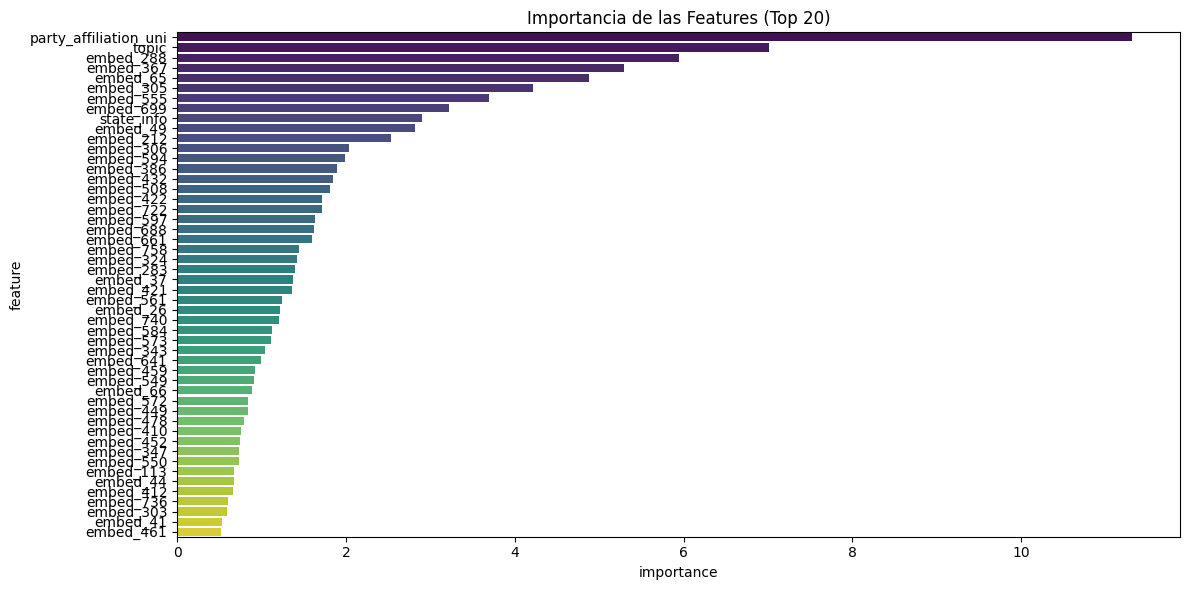

In [154]:
# Obtener importancias
importances = catboost_model.get_feature_importance()
features = X_train.columns

# Crear DataFrame ordenado
importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(50), x="importance", y="feature", palette="viridis")
plt.title("Importancia de las Features (Top 20)")
plt.tight_layout()
plt.show()

Vemos que el `topic` se ha convertido en la variable más importante del modelo. 

### Subida a Kaggle

In [ ]:
# Cargamos los embeddings del dataset de test
embed_test_df = pd.read_csv("../../../../data/processed/embedded_test.csv")
embed_test_df.head(3)

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_758,embed_759,embed_760,embed_761,embed_762,embed_763,embed_764,embed_765,embed_766,embed_767
0,-0.256534,-0.442703,-0.229835,-0.161784,-0.038800,0.096567,0.041233,0.110703,-0.115799,-0.156141,...,-0.063853,-0.231764,0.186249,-0.150920,0.206585,0.012226,-0.105509,0.109827,0.205418,0.471980
1,0.119998,0.102028,0.070019,-0.099779,-0.097966,-0.171420,0.263679,0.290038,0.101147,-0.265210,...,0.025386,-0.245336,0.228878,-0.069965,0.084169,0.084330,0.084217,-0.077824,0.355140,0.495040
2,-0.020408,-0.309853,-0.274061,-0.128203,-0.072202,0.110596,0.080832,0.139750,-0.237371,-0.172731,...,-0.019725,-0.000970,0.382410,-0.257818,0.179841,-0.370970,-0.094966,-0.148900,0.162975,0.542853


In [ ]:
# Cargamos el dataset de test original para obtener los statements
df_test = pd.read_csv("../../../../data/processed/test_limpieza_v2.csv")
df_test_id = df_test["id"]
df_test.head(2)

,id,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_affiliation_uni,party_affiliation_category_map
0,dc32e5ffa8b,Five members of [the Common Cause Georgia] boa...,"campaign-finance,ethics,government-regulation",kasim-reed,non-define,non-define,democrat,democrat,political-affiliation
1,aa49bb41cab,Theres no negative advertising in my campaign ...,elections,bill-mccollum,non-define,Florida,republican,republican,political-affiliation


In [142]:
# Aplicamos BERTopic
test_topics, _ = topic_model.fit_transform(df_test["statement"])
test_topics_subject, _ = topic_model.fit_transform(df_test["subject"])

2025-05-18 20:59:56,941 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/120 [00:00<?, ?it/s]

2025-05-18 21:00:31,039 - BERTopic - Embedding - Completed ✓
2025-05-18 21:00:31,040 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-18 21:00:52,117 - BERTopic - Dimensionality - Completed ✓
2025-05-18 21:00:52,122 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-18 21:00:52,334 - BERTopic - Cluster - Completed ✓
2025-05-18 21:00:52,339 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-18 21:00:52,543 - BERTopic - Representation - Completed ✓
2025-05-18 21:00:52,788 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/120 [00:00<?, ?it/s]

2025-05-18 21:01:04,292 - BERTopic - Embedding - Completed ✓
2025-05-18 21:01:04,293 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-18 21:01:28,578 - BERTopic - Dimensionality - Completed ✓
2025-05-18 21:01:28,580 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-18 21:01:28,737 - BERTopic - Cluster - Completed ✓
2025-05-18 21:01:28,741 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-18 21:01:28,898 - BERTopic - Representation - Completed ✓


In [160]:
df_test_topic = embed_test_df.copy()
df_test_topic["topic"] = test_topics
df_test = df_test.drop(columns=["id","statement","subject","speaker","speaker_job","party_affiliation_category_map","party_affiliation"])
df_test_topic.head(3)

filename = f"../../data/processed/test_topics.csv"
df_test_topic.to_csv(filename, index=False)
print(f"Topics guardadas en {filename}")

Topics guardadas en ../../data/processed/test_topics.csv


In [161]:
df_test_topic["topic_subject"] = test_topics_subject
df_test_topic[df_test.columns] = df_test

['embed_0',
 'embed_1',
 'embed_2',
 'embed_3',
 'embed_4',
 'embed_5',
 'embed_6',
 'embed_7',
 'embed_8',
 'embed_9',
 'embed_10',
 'embed_11',
 'embed_12',
 'embed_13',
 'embed_14',
 'embed_15',
 'embed_16',
 'embed_17',
 'embed_18',
 'embed_19',
 'embed_20',
 'embed_21',
 'embed_22',
 'embed_23',
 'embed_24',
 'embed_25',
 'embed_26',
 'embed_27',
 'embed_28',
 'embed_29',
 'embed_30',
 'embed_31',
 'embed_32',
 'embed_33',
 'embed_34',
 'embed_35',
 'embed_36',
 'embed_37',
 'embed_38',
 'embed_39',
 'embed_40',
 'embed_41',
 'embed_42',
 'embed_43',
 'embed_44',
 'embed_45',
 'embed_46',
 'embed_47',
 'embed_48',
 'embed_49',
 'embed_50',
 'embed_51',
 'embed_52',
 'embed_53',
 'embed_54',
 'embed_55',
 'embed_56',
 'embed_57',
 'embed_58',
 'embed_59',
 'embed_60',
 'embed_61',
 'embed_62',
 'embed_63',
 'embed_64',
 'embed_65',
 'embed_66',
 'embed_67',
 'embed_68',
 'embed_69',
 'embed_70',
 'embed_71',
 'embed_72',
 'embed_73',
 'embed_74',
 'embed_75',
 'embed_76',
 'embed_7

In [162]:
from catboost import Pool
test_pool = Pool(df_test_topic, cat_features=cat_features)
y_pred_test = catboost_model.predict(test_pool)

In [163]:
# Guardar predicciones
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output = pd.DataFrame({
    "id": df_test_id,
    "label": y_pred_test.astype(int)
})
filename = f"../3_summision/DistilBERT_Statements_Topics_{current_date}.csv"
output.to_csv(filename, index=False)
print(f"Predicciones guardadas en {filename}")

Predicciones guardadas en ../3_summision/DistilBERT_Statements_Topics_2025-05-18_21-04-47.csv


## CatBoost top50

In [209]:
# Filtrar top 50
top_50_features = importance_df.head(50)["feature"].tolist()
statements_top50 = train_df[top_50_features]

In [267]:
# Filtrar cat_features que estén en el top 50
cat_features_top = [col for col in cat_features if col in top_50_features]

# Reducir X a esas columnas
X_train_top = X_train[top_50_features]
X_val_top = X_val[top_50_features]

# Declaración de Pools
train_pool_top = Pool(
    data=X_train_top,
    label=y_train,
    cat_features=cat_features_top
)

val_pool_top = Pool(
    data=X_val_top,
    label=y_val,
    cat_features=cat_features_top
)

# Crear un nuevo modelo para top 50
catboost_top50 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=8,
    eval_metric='F1',
    l2_leaf_reg=1,
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=100
)

# Entrenar el modelo con las top 50 features
catboost_top50.fit(
    train_pool_top,
    eval_set=val_pool_top,
    early_stopping_rounds=50,
    use_best_model=True
)

0:	learn: 0.5756419	test: 0.5611453	best: 0.5611453 (0)	total: 16.8ms	remaining: 16.8s
100:	learn: 0.6904633	test: 0.6273622	best: 0.6286392 (98)	total: 1.87s	remaining: 16.6s
200:	learn: 0.7251013	test: 0.6310871	best: 0.6332594 (197)	total: 3.57s	remaining: 14.2s
300:	learn: 0.7613116	test: 0.6323821	best: 0.6345333 (286)	total: 5.1s	remaining: 11.8s
400:	learn: 0.8052950	test: 0.6339903	best: 0.6362739 (366)	total: 6.54s	remaining: 9.76s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6362739074
bestIteration = 366

Shrink model to first 367 iterations.


In [268]:
# Predicción
y_pred_top = catboost_top50.predict(val_pool_top)

# Evaluar
from sklearn.metrics import classification_report

print("\nClassification Report (Top 50 features):")
print(classification_report(y_val, y_pred_top, digits=3))


Classification Report (Top 50 features):
              precision    recall  f1-score   support

           0      0.485     0.604     0.538       631
           1      0.751     0.651     0.698      1159

    accuracy                          0.635      1790
   macro avg      0.618     0.628     0.618      1790
weighted avg      0.658     0.635     0.642      1790



### Subida a Kaggle

In [269]:
# Filtramos el dataset de test con los topics por las 50 caracteristicas mas relevantes
df_test_top50 = df_test_topic[top_50_features]
df_test_top50.head(3)

,party_affiliation_uni,topic,embed_288,embed_367,embed_65,embed_305,embed_555,embed_699,state_info,embed_49,...,embed_452,embed_347,embed_550,embed_113,embed_44,embed_412,embed_736,embed_303,embed_41,embed_461
0,democrat,-1,0.127737,0.274597,0.153955,-0.005691,0.282455,-0.168341,non-define,-0.278725,...,0.176483,-0.192184,0.001050,-0.505628,0.337475,-0.215531,-0.026405,-0.265658,-0.010609,-0.337674
1,republican,54,0.224597,0.292691,0.020102,0.103378,0.077197,-0.045878,Florida,-0.163055,...,-0.211621,-0.025456,-0.083223,-0.406842,-0.012775,-0.251722,-0.131967,0.052453,-0.125053,-0.302967
2,republican,0,0.153564,0.183268,0.084500,0.174290,0.321480,0.032523,Texas,-0.260240,...,-0.146222,-0.431943,0.174520,-0.503516,0.058911,-0.121740,-0.211942,0.032049,0.118608,-0.091723


In [270]:
# Obtenemos las predicciones
test_pool_top = Pool(df_test_top50, cat_features=cat_features_top)
y_pred_test = catboost_top50.predict(test_pool_top)

# Guardar predicciones
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output = pd.DataFrame({
    "id": df_test_id,
    "label": y_pred_test.astype(int)
})
filename = f"../3_summision/DistilBERT_Statements_Topics_top50_{current_date}.csv"
output.to_csv(filename, index=False)
print(f"Predicciones guardadas en {filename}")

Predicciones guardadas en ../3_summision/DistilBERT_Statements_Topics_top50_2025-05-18_21-37-12.csv


In [271]:
from sklearn.metrics import f1_score
import numpy as np

probs = catboost_top50.predict_proba(val_pool_top)
print(probs.shape)

thresholds = np.linspace(0, 1, 1001)

f1_macro_scores = []

for t in thresholds:
    y_pred = (probs[:, 1] >= t).astype(int)
    score = f1_score(y_val, y_pred, average='macro')  # F1 macro
    f1_macro_scores.append(score)

# 3. Seleccionar el mejor umbral
best_threshold = thresholds[np.argmax(f1_macro_scores)]
best_f1 = max(f1_macro_scores)

print(f"Mejor umbral: {best_threshold:.2f}")
print(f"F1-score macro: {best_f1:.4f}")

(1790, 2)
Mejor umbral: 0.50
F1-score macro: 0.6195


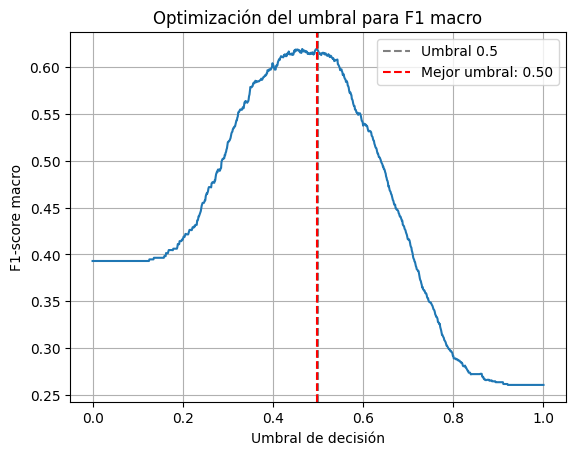

In [272]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_macro_scores)
plt.axvline(x=0.5, color='gray', linestyle='--', label='Umbral 0.5')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Mejor umbral: {best_threshold:.2f}')
plt.xlabel('Umbral de decisión')
plt.ylabel('F1-score macro')
plt.title('Optimización del umbral para F1 macro')
plt.legend()
plt.grid(True)
plt.show()


In [273]:
# Obtener predicciones finales ajustadas
test_pool_top = Pool(df_test_top50, cat_features=cat_features_top)
y_pred_test = catboost_top50.predict(test_pool_top)

test_probs_top = catboost_top50.predict_proba(test_pool_top)
y_test_pred = (test_probs_top[:, 1] >= best_threshold).astype(int)

In [274]:
# Guardar predicciones
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output = pd.DataFrame({
    "id": df_test_id,
    "label": y_pred_test.astype(int)
})
filename = f"../3_summision/DistilBERT_Statements_Topics_top50_threshold_{current_date}.csv"
output.to_csv(filename, index=False)
print(f"Predicciones guardadas en {filename}")

Predicciones guardadas en ../3_summision/DistilBERT_Statements_Topics_top50_threshold_2025-05-18_21-37-16.csv
